# Face Recognition Model Tuning Notebook

This notebook allows you to:
1. Train face recognition models with reference photos
2. Analyze performance on labeled photo datasets
3. Fine-tune parameters (tolerance, model, encoding_model, num_jitters)
4. Track experiments and compare results

## Prerequisites
- Install dependencies: `pip install -r requirements.txt`
- Install face_recognition: See `docs/FACE_RECOGNITION_LOCAL_SETUP.md`
- Place reference photos in `reference_photos/` directory

---
## Section 1: Setup & Configuration

In [1]:
# Standard library imports
import os
import sys
import glob
import json
import time
from datetime import datetime
from pathlib import Path

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

# Face recognition
import face_recognition
from PIL import Image
import yaml

# Add scripts directory to path
PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.insert(0, str(PROJECT_ROOT))
sys.path.insert(0, str(PROJECT_ROOT / "scripts"))

from scripts.face_recognizer.providers.local_provider import LocalFaceRecognitionProvider

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print(f"Project root: {PROJECT_ROOT}")
print(f"Face recognition version: {face_recognition.__version__ if hasattr(face_recognition, '__version__') else 'unknown'}")

/Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/venv/lib/python3.12/site-packages/face_recognition_models/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


Project root: /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer
Face recognition version: 1.2.3


In [2]:
# Load configuration
CONFIG_PATH = PROJECT_ROOT / "config" / "config.yaml"

if CONFIG_PATH.exists():
    with open(CONFIG_PATH, 'r') as f:
        config = yaml.safe_load(f)
    print("Loaded configuration from config.yaml")
else:
    # Default configuration
    config = {
        'face_recognition': {
            'reference_photos_dir': './reference_photos',
            'tolerance': 0.6,
            'local': {
                'model': 'hog',
                'encoding_model': 'large',
                'training': {'num_jitters': 50},
                'recognition': {'num_jitters': 1}
            }
        }
    }
    print("Using default configuration")

# Extract face recognition settings
face_config = config.get('face_recognition', {})
local_config = face_config.get('local', {})

print(f"\nCurrent settings:")
print(f"  Reference photos dir: {face_config.get('reference_photos_dir', './reference_photos')}")
print(f"  Tolerance: {face_config.get('tolerance', 0.6)}")
print(f"  Provider: {face_config.get('provider', 'local')}")
print(f"  Thumbnail size: {local_config.get('thumbnail_size', 'w256h256')}")
print(f"  Detection model: {local_config.get('model', 'hog')}")
print(f"  Encoding model: {local_config.get('encoding_model', 'large')}")
print(f"  Training num_jitters: {local_config.get('training', {}).get('num_jitters', 50)}")
print(f"  Recognition num_jitters: {local_config.get('recognition', {}).get('num_jitters', 1)}")

Loaded configuration from config.yaml

Current settings:
  Reference photos dir: ./reference_photos
  Tolerance: 0.6
  Provider: local
  Thumbnail size: w256h256
  Detection model: hog
  Encoding model: large
  Training num_jitters: 50
  Recognition num_jitters: 1


---
## Section 2: Reference Photos & Training

In [3]:
# Find reference photos
REFERENCE_DIR = PROJECT_ROOT / face_config.get('reference_photos_dir', './reference_photos').lstrip('./')
IMAGE_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.heic']

def get_reference_photos(reference_dir, extensions):
    """Find all reference photos in directory."""
    photos = []
    for ext in extensions:
        photos.extend(glob.glob(str(reference_dir / f"*{ext}")))
        photos.extend(glob.glob(str(reference_dir / f"*{ext.upper()}")))
    # Filter out system files
    photos = [p for p in photos if not os.path.basename(p).startswith('.')]
    return sorted(list(set(photos)))

reference_photos = get_reference_photos(REFERENCE_DIR, IMAGE_EXTENSIONS)
print(f"Found {len(reference_photos)} reference photos in {REFERENCE_DIR}")

Found 25 reference photos in /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/reference_photos


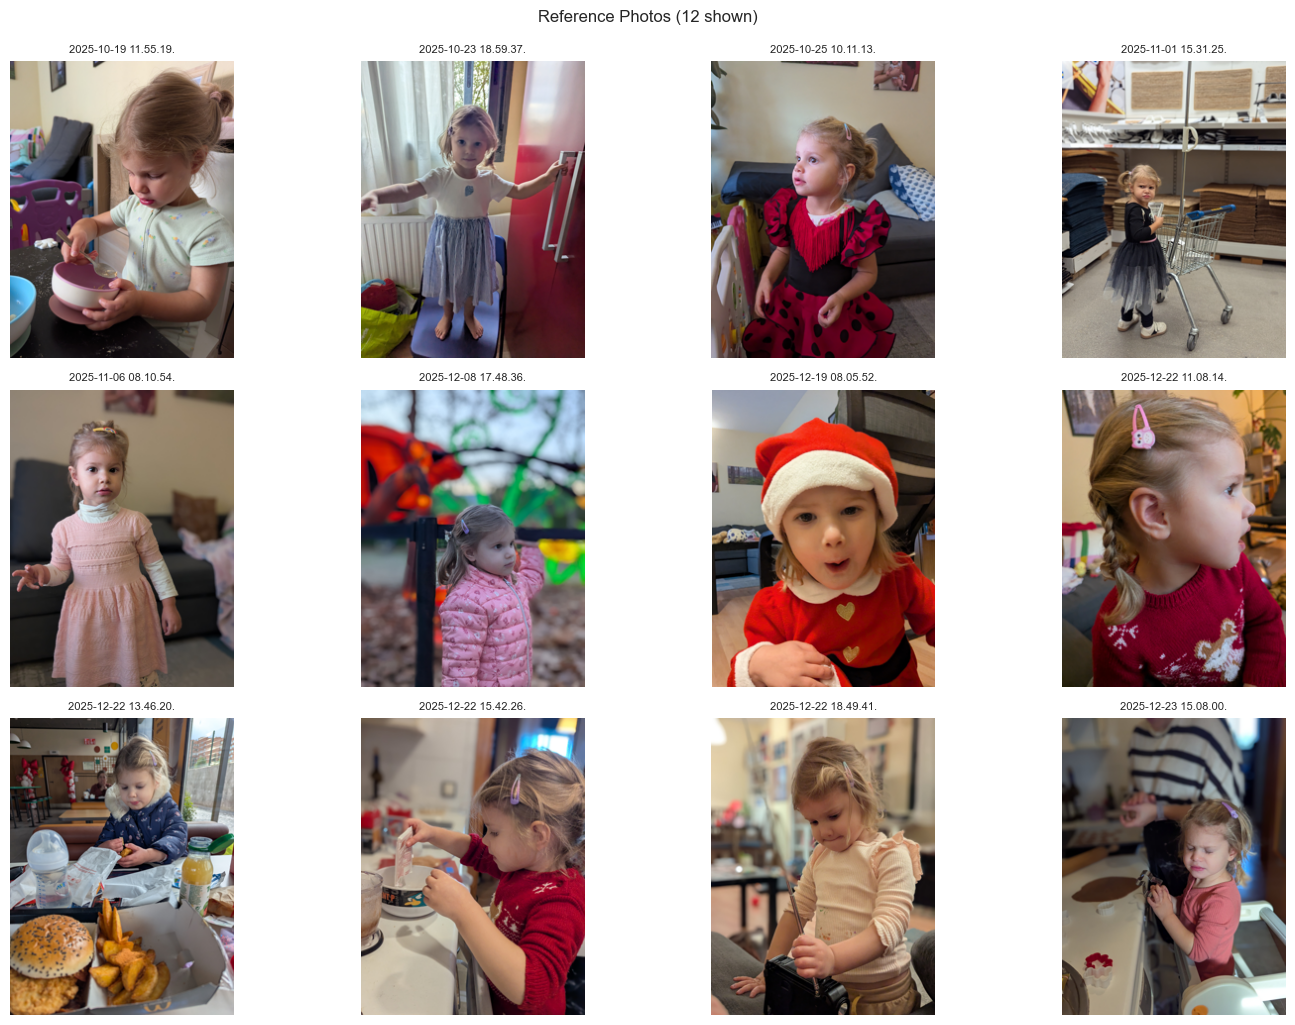

In [4]:
# Display reference photos in a grid
def display_photos_grid(photo_paths, max_photos=12, figsize=(15, 10)):
    """Display photos in a grid layout."""
    n_photos = min(len(photo_paths), max_photos)
    if n_photos == 0:
        print("No photos to display")
        return
    
    cols = min(4, n_photos)
    rows = (n_photos + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, photo_path in enumerate(photo_paths[:max_photos]):
        row, col = idx // cols, idx % cols
        try:
            img = Image.open(photo_path)
            img.thumbnail((300, 300))
            axes[row, col].imshow(img)
            axes[row, col].set_title(os.path.basename(photo_path)[:20], fontsize=8)
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f"Error: {e}", ha='center', va='center')
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for idx in range(n_photos, rows * cols):
        row, col = idx // cols, idx % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Reference Photos ({n_photos} shown)", y=1.02)
    plt.show()

display_photos_grid(reference_photos)

In [5]:
def train_model(reference_photos, model='hog', encoding_model='large', num_jitters=50):
    """Train face recognition model with given parameters."""
    provider_config = {
        'model': model,
        'encoding_model': encoding_model,
        'num_jitters': num_jitters,
        'tolerance': 0.6  # Default, will be overridden during matching
    }
    
    provider = LocalFaceRecognitionProvider(provider_config)
    
    start_time = time.time()
    num_faces = provider.load_reference_photos(reference_photos)
    training_time = time.time() - start_time
    
    return provider, num_faces, training_time

# Train with default parameters
print("Training model with default parameters...")
provider, num_faces, training_time = train_model(
    reference_photos,
    model=local_config.get('model', 'hog'),
    encoding_model=local_config.get('encoding_model', 'large'),
    num_jitters=local_config.get('training', {}).get('num_jitters', 50)
)

print(f"\nTraining Results:")
print(f"  Photos processed: {len(reference_photos)}")
print(f"  Faces detected: {num_faces}")
print(f"  Success rate: {100.0 * num_faces / len(reference_photos):.1f}%")
print(f"  Training time: {training_time:.2f}s")

Training model with default parameters...


No faces found in reference photo: /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/reference_photos/2025-10-19 11.55.19.jpg
Multiple faces found in /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/reference_photos/2025-10-23 18.59.37.jpg. Using the first face only.
Multiple faces found in /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/reference_photos/2025-12-08 17.48.36.jpg. Using the first face only.
No faces found in reference photo: /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/reference_photos/2025-12-22 11.08.14.jpg
Multiple faces found in /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/reference_photos/2025-12-22 13.46.20.jpg. Using the first face only.
No faces found in reference photo: /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/reference_photos/2025-12-22 15.42.26.jpg
No faces found in reference photo: /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/reference_photos/2025-12-22 18.49.41.j


Training Results:
  Photos processed: 25
  Faces detected: 18
  Success rate: 72.0%
  Training time: 60.08s


---
## Section 3: Test Dataset Creation Helper

Create a labeled test dataset by organizing photos into folders:
```
notebooks/data/test_photos/
    match/       # Photos containing the target person
    no_match/    # Photos NOT containing the target person
```

In [6]:
# Test dataset paths
TEST_DATA_DIR = Path(os.getcwd()) / "data" / "test_photos"
MATCH_DIR = TEST_DATA_DIR / "match"
NO_MATCH_DIR = TEST_DATA_DIR / "no_match"

def create_test_dataset_folders():
    """Create the folder structure for test dataset."""
    MATCH_DIR.mkdir(parents=True, exist_ok=True)
    NO_MATCH_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Created test dataset folders:")
    print(f"  Match folder: {MATCH_DIR}")
    print(f"  No-match folder: {NO_MATCH_DIR}")
    print(f"\nPlace your test photos in these folders and re-run the next cell.")

def load_test_dataset():
    """Load test dataset from folder structure."""
    dataset = []
    
    # Load match photos
    if MATCH_DIR.exists():
        for ext in IMAGE_EXTENSIONS:
            for photo in glob.glob(str(MATCH_DIR / f"*{ext}")):
                if not os.path.basename(photo).startswith('.'):
                    dataset.append({'file_path': photo, 'ground_truth': 'match'})
            for photo in glob.glob(str(MATCH_DIR / f"*{ext.upper()}")):
                if not os.path.basename(photo).startswith('.'):
                    dataset.append({'file_path': photo, 'ground_truth': 'match'})
    
    # Load no-match photos
    if NO_MATCH_DIR.exists():
        for ext in IMAGE_EXTENSIONS:
            for photo in glob.glob(str(NO_MATCH_DIR / f"*{ext}")):
                if not os.path.basename(photo).startswith('.'):
                    dataset.append({'file_path': photo, 'ground_truth': 'no_match'})
            for photo in glob.glob(str(NO_MATCH_DIR / f"*{ext.upper()}")):
                if not os.path.basename(photo).startswith('.'):
                    dataset.append({'file_path': photo, 'ground_truth': 'no_match'})
    
    return pd.DataFrame(dataset)

# Create folders if they don't exist
if not TEST_DATA_DIR.exists():
    create_test_dataset_folders()
else:
    print(f"Test dataset folder exists: {TEST_DATA_DIR}")

Created test dataset folders:
  Match folder: /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/notebooks/data/test_photos/match
  No-match folder: /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/notebooks/data/test_photos/no_match

Place your test photos in these folders and re-run the next cell.


In [7]:
# Load and display test dataset
test_df = load_test_dataset()

if len(test_df) == 0:
    print("No test photos found!")
    print(f"\nPlease add photos to:")
    print(f"  {MATCH_DIR}  (photos with the target person)")
    print(f"  {NO_MATCH_DIR}  (photos without the target person)")
else:
    print(f"Loaded {len(test_df)} test photos:")
    print(test_df['ground_truth'].value_counts())
    print(f"\nDataset preview:")
    display(test_df.head(10))

No test photos found!

Please add photos to:
  /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/notebooks/data/test_photos/match  (photos with the target person)
  /Users/alex3m6/Dropbox/projects/dropboxFamilyPhotoOrganizer/notebooks/data/test_photos/no_match  (photos without the target person)


---
## Section 4: Run Evaluation

In [ ]:
def evaluate_model(provider, test_df, tolerance=0.6):
    """Evaluate model on test dataset."""
    results = []
    
    for idx, row in test_df.iterrows():
        file_path = row['file_path']
        ground_truth = row['ground_truth']
        
        try:
            start_time = time.time()
            
            # Load image
            image = face_recognition.load_image_file(file_path)
            image_bytes = open(file_path, 'rb').read()
            
            # Find matches
            matches, total_faces = provider.find_matches_in_image(
                image_bytes, 
                source=file_path,
                tolerance=tolerance
            )
            
            processing_time = time.time() - start_time
            
            # Determine prediction
            is_match = len(matches) > 0
            confidence = matches[0].get('confidence', 0.0) if matches else 0.0
            
            results.append({
                'file_path': file_path,
                'ground_truth': ground_truth,
                'prediction': 'match' if is_match else 'no_match',
                'is_correct': (ground_truth == 'match') == is_match,
                'confidence': confidence,
                'faces_detected': total_faces,
                'matches_found': len(matches),
                'processing_time': processing_time,
                'error': None
            })
            
        except Exception as e:
            results.append({
                'file_path': file_path,
                'ground_truth': ground_truth,
                'prediction': 'error',
                'is_correct': False,
                'confidence': 0.0,
                'faces_detected': 0,
                'matches_found': 0,
                'processing_time': 0.0,
                'error': str(e)
            })
    
    return pd.DataFrame(results)

# Run evaluation if we have test data
if len(test_df) > 0:
    print(f"Evaluating model on {len(test_df)} test photos...")
    results_df = evaluate_model(provider, test_df, tolerance=face_config.get('tolerance', 0.6))
    
    print(f"\nEvaluation complete!")
    print(f"  Correct: {results_df['is_correct'].sum()} / {len(results_df)}")
    print(f"  Errors: {(results_df['error'].notna()).sum()}")
    display(results_df.head(10))
else:
    print("No test data available. Please add test photos first.")
    results_df = pd.DataFrame()

---
## Section 5: Metrics & Visualization

In [ ]:
def calculate_metrics(results_df):
    """Calculate classification metrics."""
    # Filter out errors
    valid_df = results_df[results_df['error'].isna()].copy()
    
    if len(valid_df) == 0:
        return None
    
    y_true = (valid_df['ground_truth'] == 'match').astype(int)
    y_pred = (valid_df['prediction'] == 'match').astype(int)
    y_scores = valid_df['confidence']
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'total_samples': len(valid_df),
        'true_positives': ((y_true == 1) & (y_pred == 1)).sum(),
        'true_negatives': ((y_true == 0) & (y_pred == 0)).sum(),
        'false_positives': ((y_true == 0) & (y_pred == 1)).sum(),
        'false_negatives': ((y_true == 1) & (y_pred == 0)).sum(),
        'avg_processing_time': valid_df['processing_time'].mean()
    }
    
    # Calculate AUC if we have both classes
    if len(y_true.unique()) > 1 and y_scores.sum() > 0:
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        metrics['auc'] = auc(fpr, tpr)
    else:
        metrics['auc'] = None
    
    return metrics

if len(results_df) > 0:
    metrics = calculate_metrics(results_df)
    if metrics:
        print("Classification Metrics:")
        print(f"  Accuracy:  {metrics['accuracy']:.3f}")
        print(f"  Precision: {metrics['precision']:.3f}")
        print(f"  Recall:    {metrics['recall']:.3f}")
        print(f"  F1 Score:  {metrics['f1_score']:.3f}")
        if metrics['auc']:
            print(f"  AUC:       {metrics['auc']:.3f}")
        print(f"\nConfusion Matrix:")
        print(f"  TP: {metrics['true_positives']}  FP: {metrics['false_positives']}")
        print(f"  FN: {metrics['false_negatives']}  TN: {metrics['true_negatives']}")
        print(f"\nAvg processing time: {metrics['avg_processing_time']:.3f}s per image")

In [ ]:
def plot_metrics(results_df):
    """Create visualization plots for evaluation results."""
    valid_df = results_df[results_df['error'].isna()].copy()
    
    if len(valid_df) == 0:
        print("No valid results to plot")
        return
    
    y_true = (valid_df['ground_truth'] == 'match').astype(int)
    y_pred = (valid_df['prediction'] == 'match').astype(int)
    y_scores = valid_df['confidence']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=['No Match', 'Match'], yticklabels=['No Match', 'Match'])
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')
    
    # 2. ROC Curve
    if len(y_true.unique()) > 1 and y_scores.sum() > 0:
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        axes[0, 1].plot(fpr, tpr, 'b-', label=f'ROC (AUC = {roc_auc:.3f})')
        axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].set_title('ROC Curve')
        axes[0, 1].legend()
    else:
        axes[0, 1].text(0.5, 0.5, 'Insufficient data for ROC curve', 
                        ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('ROC Curve')
    
    # 3. Confidence Distribution
    match_conf = valid_df[valid_df['ground_truth'] == 'match']['confidence']
    no_match_conf = valid_df[valid_df['ground_truth'] == 'no_match']['confidence']
    
    if len(match_conf) > 0:
        axes[1, 0].hist(match_conf, bins=20, alpha=0.7, label='Match', color='green')
    if len(no_match_conf) > 0:
        axes[1, 0].hist(no_match_conf, bins=20, alpha=0.7, label='No Match', color='red')
    axes[1, 0].set_xlabel('Confidence Score')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Confidence Score Distribution')
    axes[1, 0].legend()
    
    # 4. Precision-Recall Curve
    if len(y_true.unique()) > 1 and y_scores.sum() > 0:
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        axes[1, 1].plot(recall, precision, 'b-')
        axes[1, 1].set_xlabel('Recall')
        axes[1, 1].set_ylabel('Precision')
        axes[1, 1].set_title('Precision-Recall Curve')
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient data for PR curve',
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Precision-Recall Curve')
    
    plt.tight_layout()
    plt.show()

if len(results_df) > 0:
    plot_metrics(results_df)

---
## Section 6: Parameter Grid Search

In [ ]:
# Define parameter grid
# Note: Full grid can take a long time. Start with a smaller grid.

PARAM_GRID_SMALL = {
    'tolerance': [0.5, 0.6],
    'model': ['hog'],
    'encoding_model': ['large'],
    'num_jitters': [10]
}

PARAM_GRID_FULL = {
    'tolerance': [0.4, 0.5, 0.6, 0.7],
    'model': ['hog', 'cnn'],
    'encoding_model': ['small', 'large'],
    'num_jitters': [1, 10, 50]
}

# Select which grid to use
param_grid = PARAM_GRID_SMALL  # Change to PARAM_GRID_FULL for exhaustive search

# Calculate total combinations
total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)

print(f"Parameter grid: {param_grid}")
print(f"Total combinations to test: {total_combinations}")

In [ ]:
from itertools import product

def run_grid_search(test_df, reference_photos, param_grid):
    """Run grid search over parameter combinations."""
    if len(test_df) == 0:
        print("No test data available for grid search.")
        return pd.DataFrame()
    
    results = []
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))
    
    print(f"Running grid search with {len(combinations)} combinations...")
    
    for i, combo in enumerate(combinations):
        params = dict(zip(param_names, combo))
        tolerance = params.pop('tolerance')  # Tolerance is used during matching, not training
        
        print(f"\n[{i+1}/{len(combinations)}] Testing: tolerance={tolerance}, {params}")
        
        try:
            # Train model with current parameters
            provider, num_faces, training_time = train_model(
                reference_photos,
                model=params['model'],
                encoding_model=params['encoding_model'],
                num_jitters=params['num_jitters']
            )
            
            # Evaluate on test set
            eval_df = evaluate_model(provider, test_df, tolerance=tolerance)
            metrics = calculate_metrics(eval_df)
            
            if metrics:
                result = {
                    'tolerance': tolerance,
                    'model': params['model'],
                    'encoding_model': params['encoding_model'],
                    'num_jitters': params['num_jitters'],
                    'accuracy': metrics['accuracy'],
                    'precision': metrics['precision'],
                    'recall': metrics['recall'],
                    'f1_score': metrics['f1_score'],
                    'auc': metrics['auc'],
                    'training_time': training_time,
                    'avg_inference_time': metrics['avg_processing_time']
                }
                results.append(result)
                print(f"   -> Accuracy: {metrics['accuracy']:.3f}, F1: {metrics['f1_score']:.3f}")
            
        except Exception as e:
            print(f"   -> Error: {e}")
    
    return pd.DataFrame(results)

# Run grid search
if len(test_df) > 0:
    grid_results_df = run_grid_search(test_df, reference_photos, param_grid)
    
    if len(grid_results_df) > 0:
        print("\n" + "="*60)
        print("Grid Search Results (sorted by F1 Score):")
        print("="*60)
        display(grid_results_df.sort_values('f1_score', ascending=False))
else:
    print("No test data. Please add test photos to run grid search.")
    grid_results_df = pd.DataFrame()

In [ ]:
# Visualize grid search results
if len(grid_results_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: F1 Score by Tolerance
    if 'tolerance' in grid_results_df.columns:
        for model in grid_results_df['model'].unique():
            subset = grid_results_df[grid_results_df['model'] == model]
            axes[0].plot(subset['tolerance'], subset['f1_score'], 'o-', label=model)
        axes[0].set_xlabel('Tolerance')
        axes[0].set_ylabel('F1 Score')
        axes[0].set_title('F1 Score vs Tolerance')
        axes[0].legend()
    
    # Plot 2: Accuracy vs Training Time
    scatter = axes[1].scatter(
        grid_results_df['training_time'],
        grid_results_df['accuracy'],
        c=grid_results_df['f1_score'],
        cmap='viridis',
        s=100
    )
    plt.colorbar(scatter, ax=axes[1], label='F1 Score')
    axes[1].set_xlabel('Training Time (s)')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy vs Training Time')
    
    plt.tight_layout()
    plt.show()
    
    # Best parameters
    if len(grid_results_df) > 0:
        best = grid_results_df.loc[grid_results_df['f1_score'].idxmax()]
        print("\nBest Parameters (by F1 Score):")
        print(f"  Tolerance: {best['tolerance']}")
        print(f"  Model: {best['model']}")
        print(f"  Encoding Model: {best['encoding_model']}")
        print(f"  Num Jitters: {best['num_jitters']}")
        print(f"  F1 Score: {best['f1_score']:.3f}")
        print(f"  Accuracy: {best['accuracy']:.3f}")

---
## Section 7: Experiment Tracking

In [ ]:
EXPERIMENTS_DIR = Path(os.getcwd()) / "experiments"
EXPERIMENTS_FILE = EXPERIMENTS_DIR / "experiments.json"

def save_experiment(params, dataset_info, metrics, notes=""):
    """Save an experiment to the experiments file."""
    EXPERIMENTS_DIR.mkdir(parents=True, exist_ok=True)
    
    # Load existing experiments
    experiments = []
    if EXPERIMENTS_FILE.exists():
        with open(EXPERIMENTS_FILE, 'r') as f:
            experiments = json.load(f)
    
    # Create new experiment
    experiment = {
        'id': f"exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        'timestamp': datetime.now().isoformat(),
        'parameters': params,
        'dataset': dataset_info,
        'results': metrics,
        'notes': notes
    }
    
    experiments.append(experiment)
    
    # Save back
    with open(EXPERIMENTS_FILE, 'w') as f:
        json.dump(experiments, f, indent=2, default=str)
    
    print(f"Saved experiment: {experiment['id']}")
    return experiment

def load_experiments():
    """Load all saved experiments."""
    if not EXPERIMENTS_FILE.exists():
        return []
    
    with open(EXPERIMENTS_FILE, 'r') as f:
        return json.load(f)

def experiments_to_dataframe(experiments):
    """Convert experiments to a DataFrame for analysis."""
    rows = []
    for exp in experiments:
        row = {
            'id': exp['id'],
            'timestamp': exp['timestamp'],
            'notes': exp.get('notes', '')
        }
        row.update(exp.get('parameters', {}))
        row.update({f"dataset_{k}": v for k, v in exp.get('dataset', {}).items()})
        row.update(exp.get('results', {}))
        rows.append(row)
    
    return pd.DataFrame(rows)

print(f"Experiments will be saved to: {EXPERIMENTS_FILE}")

In [ ]:
# Save current experiment (if we have results)
if len(results_df) > 0 and metrics:
    current_params = {
        'tolerance': face_config.get('tolerance', 0.6),
        'model': local_config.get('model', 'hog'),
        'encoding_model': local_config.get('encoding_model', 'large'),
        'num_jitters': local_config.get('training', {}).get('num_jitters', 50)
    }
    
    dataset_info = {
        'name': 'test_photos',
        'match_count': len(test_df[test_df['ground_truth'] == 'match']),
        'no_match_count': len(test_df[test_df['ground_truth'] == 'no_match']),
        'total': len(test_df)
    }
    
    experiment = save_experiment(
        params=current_params,
        dataset_info=dataset_info,
        metrics=metrics,
        notes="Initial experiment"
    )
    print(f"\nExperiment saved with ID: {experiment['id']}")
else:
    print("No results to save. Run evaluation first.")

In [ ]:
# Load and display all experiments
experiments = load_experiments()

if experiments:
    exp_df = experiments_to_dataframe(experiments)
    print(f"Loaded {len(experiments)} experiments:\n")
    display(exp_df[['id', 'timestamp', 'tolerance', 'model', 'accuracy', 'f1_score', 'notes']].tail(10))
else:
    print("No experiments saved yet.")

In [ ]:
# Compare experiments over time
if experiments and len(experiments) > 1:
    exp_df = experiments_to_dataframe(experiments)
    exp_df['timestamp'] = pd.to_datetime(exp_df['timestamp'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Metrics over time
    axes[0].plot(exp_df['timestamp'], exp_df['accuracy'], 'o-', label='Accuracy')
    axes[0].plot(exp_df['timestamp'], exp_df['f1_score'], 's-', label='F1 Score')
    if 'precision' in exp_df.columns:
        axes[0].plot(exp_df['timestamp'], exp_df['precision'], '^-', label='Precision')
    if 'recall' in exp_df.columns:
        axes[0].plot(exp_df['timestamp'], exp_df['recall'], 'v-', label='Recall')
    axes[0].set_xlabel('Timestamp')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Metrics Over Time')
    axes[0].legend()
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: F1 Score by Parameters
    if 'tolerance' in exp_df.columns:
        exp_df_sorted = exp_df.sort_values('f1_score', ascending=True)
        labels = [f"tol={row['tolerance']}, {row['model']}" for _, row in exp_df_sorted.iterrows()]
        axes[1].barh(range(len(labels)), exp_df_sorted['f1_score'])
        axes[1].set_yticks(range(len(labels)))
        axes[1].set_yticklabels(labels)
        axes[1].set_xlabel('F1 Score')
        axes[1].set_title('F1 Score by Configuration')
    
    plt.tight_layout()
    plt.show()
else:
    print("Need at least 2 experiments to compare.")

---
## Quick Reference: Parameter Guidelines

| Parameter | Values | Recommendation |
|-----------|--------|----------------|
| `tolerance` | 0.4-0.7 | Start with 0.6, lower for stricter matching |
| `model` | hog, cnn | Use `hog` for speed, `cnn` for accuracy (requires GPU) |
| `encoding_model` | small, large | Use `large` for better accuracy |
| `num_jitters` | 1-100 | Higher = more robust, but slower. Use 50 for training, 1 for inference |

### Workflow
1. Add reference photos to `reference_photos/`
2. Add test photos to `notebooks/data/test_photos/match/` and `no_match/`
3. Run training and evaluation
4. Adjust parameters and re-run
5. Save experiments to track progress